<a href="https://colab.research.google.com/github/hopesowle/Sowle_BIX_F23/blob/main/Exercise4_foraging_and_rl_and_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4: Foraging and reinforcement learning**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Investigation of patchy environment random initialization effects on foraging agents with different strategies.
1. Investigation of various actor-critic agents in a new type of dynamic bandit task - one where one arm becomes *more* rewarding partway through each experiment.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.

---
## Section 1 - Foraging [30 pt]

In Lab 7, you investigated how random search, chemotaxis, and infotaxis agents behaved in a "patchy" foraging environment. We didn't get to testing out the effects of random initializations in class. In this section of the homework you will carry out that analysis.

Following the environment patches as bushes metaphor, different random seeds determine where the random bushes grow.

### Question 1.1 [4 pt]
Why is it important to check multiple random seeds when comparing foraging strategies in patchy environments?

In [ ]:
# It is important to check multiple random seeds when comparing foraging strategies
# in patchy environments, because behavior of agents can change based on where the
# patchy environments and agents are "spawned". This is especially true for info and
# chemotaxi agents that depend on an accumulator.

# In the following experiments, we can see that random can actually perform pretty
# well when compared to chemo and infotaxis if the patches are generated far from
# the starting point of the agents. In contrast, chemo and infotaxis perform much
# worse when the patches are generated far from their starting point.

### In the code cells below, run and fill in code as needed according to the text instructions before each one. Feel free to refer to lab 7 for help.

Change the directory to where we want to clone in the specific explorationlib code library branch.

In [2]:
cd /content

/content


Clone in the `target-patch-dev` explorationlib branch (the branch that has our new patchy environment functions).

In [3]:
!git clone -b target-patch-dev https://github.com/coaxlab/explorationlib

Cloning into 'explorationlib'...
remote: Enumerating objects: 769, done.
remote: Counting objects: 100% (284/284), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 769 (delta 210), reused 223 (delta 166), pack-reused 485
Receiving objects: 100% (769/769), 16.64 MiB | 10.55 MiB/s, done.
Resolving deltas: 100% (463/463), done.


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [4]:
cd /content/explorationlib

/content/explorationlib


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [5]:
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-7gz_4viw
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-7gz_4viw
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Preparing metadata (setup.py) ... done
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14215 sha256=71bfb3fe0344db07b6ca6c454d054c595db20e7ebc13255b1beba2dc5acfafb2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ocml7fk2/wheels/b0/53/2e/e282706624110bc964538d7840bef68fef2bc1865a87e3016e
Successfully built gym-maze


Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [6]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/content/explorationlib/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create a new patchy environment [2 pt]

In the code block below, set up a new patch environment like our foraging lab in the following way:
- Have there be 4 patches of 15 targets each.
- Have each patch have radius 3.
- Set the random seed to 1257.

In [ ]:
# noise and missing scents
p_scent = 0.5
noise_sigma = 1

# shared agent parameters
num_experiments = 50
num_steps = 400
seed_value = 4257

# environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 4
n_per_patch = 15
radius = 3
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)


### Visualize the patchy environment [2 pt]
In the code cell below, make a plot of the patchy environment you just made.

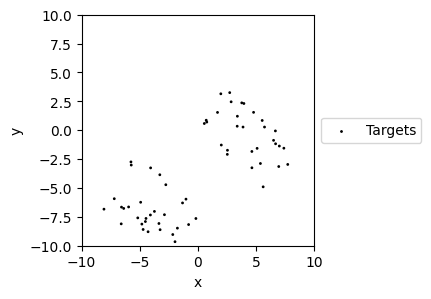

In [ ]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Create the agents [2 pt]
In the code cell below, create a random search, chemotaxis, and infotaxis agent like we did in Lab 7.

In [ ]:
# Random search agent
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

drift_rate = 1
threshold = 3

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)


# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

[4257]

### Run the experiments [2 pt]
In the code cell below, run 50 experiments of 400 steps each for each of the agents. Note - you may have set the number of experiments and steps earlier during your environment setup code.

In [ ]:
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualize proportion of time spent on patches [2 pt]
In the code cell below:
- Plot bar plots with error bars for the proportion of time spent on patches for each agent.
- Plot a histogram for the proportion of time spent on patches for each agent.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

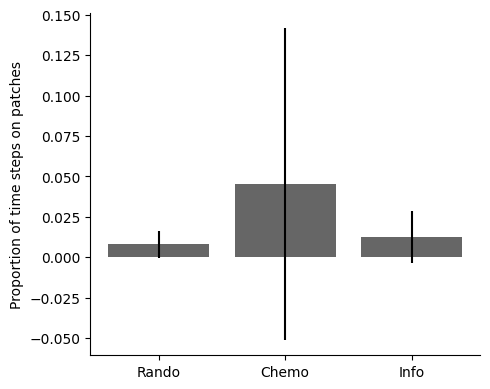

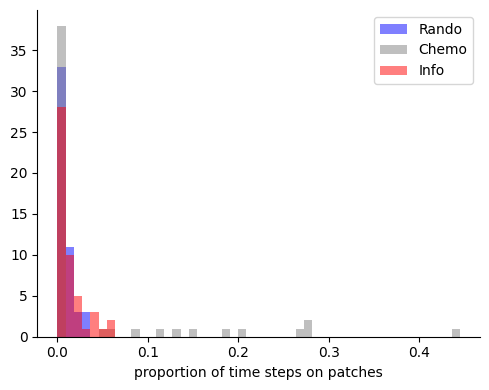

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["blue", "grey", "red"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Visualize total reward [2 pt]
In the code cell below:
- Plot bar plots with error bars for the total reward for each agent.
- Plot a histogram of total reward for each agent.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

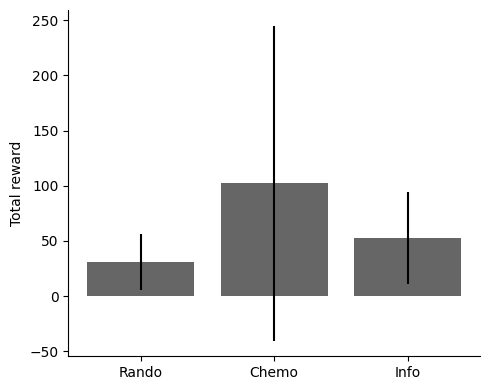

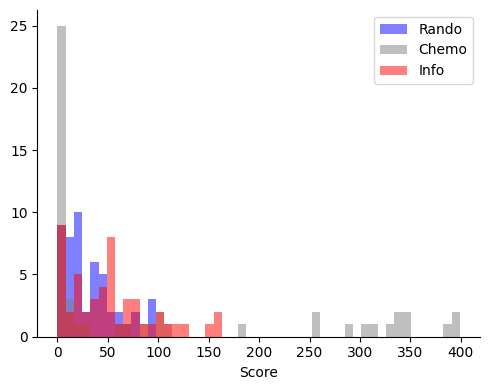

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["blue", "grey", "red"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Visualize agent deaths [2 pt]
In the code cell below, plot a bar plot of the number of deaths for each agent type.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

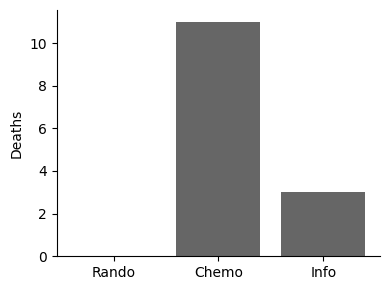

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["blue", "grey", "red"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Question 1.2 [4 pt]
Describe the performance of each agent type according to each of the metrics (on-patch proportion, total reward, deaths). Why do you think this pattern of performance occured?

In [ ]:
# Random agents appear to spend the largest proportion of time spent on patches,
# followed by chemotaxi (although quite variable), and lastly infotaxi agents.
# Random agents also appear to have the largest total reward and the lowest number
# of death, at almost 0 death. Comparatively, the chemotaxi agents have the second
# largest total reward, despite this being the most variable by far. Chemotaxi agents
# also have the second most amount of deaths, but the deaths are fairly comparable
# betweem chemo and infotaxis, between 40 ad 50. This leaves info taxis with the
# least amount of time spent on patches, the lowest total reward, and the greatest
# deaths.

# I think this pattern of performance occured because the random angents sample
# the entire environment, which makes them more likely to hit at least one target.
# As for chemo and taxi agents, it seems like they are getting stuck and dying before
# they can gain rewards.

### Question 1.3.1 [4 pt]
Re-run your simulations above, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2257, 3257, 4257, 5257.

What do you see in each performance metric of the agents with each new seed value (which specifies different unique environments)?

In [ ]:
# Write your answers here, as Python comments.

# --For seed 2257:--
# The chemo agent still has the greatest variability, but spends the greatest amount
# of time on patch, has the greatest total reward but also the most deaths (1). The
# infotaxi agent is in the middle with time spent on patch and total reward, but
# has no deaths like the random agent. The random agent spends the least amount of
# time on patch, has the lowest reward, and like I said before, also has 0 deaths.

# --For seed 3257:--
# The results are the same as for seed 2257, except all agents show no deaths.
# There is also some difference in the proportion of time spent on-patch, with less
# time across agents, but the relation between agents is the same as the last seed
# (0 deaths for both random and info and 1 death for chemo).

# --For seed 4257:--
# Again time on-patch and total reward relations are the same, but this time
# chemotaxi agents have the greatest deaths (>10), infotaxi agents have the
# second greatest deaths (~3), and random agents have no deaths.

# --For seed 5257:--
# The chemotaxi has the greatest time on patches, greatest total reward, and highest
# deaths (~35). The random agent has the second most time on patches, but still a lot
# less than chemotaxi agents. However, the random agent now has close to or the same
# total reward as infotaxis and still the least deaths (~5). This leaves infotaxis with
# the least time on patches, the roughly same total reward as random agents, and the
# second most deaths (~20)


### Question 1.3.2 [4 pt]
What does this (your results recorded in Question 1.3.1) tell you about the the difference between the Info and Chemo agents in particular in environments of this type.

In [ ]:
# It shows us that there is alot more variability in performance between the info
# and chemo agents. In particular, time spent on a patch is highly dependent on
# where the patchy environments generate in relatino to the agents. This then translates
# to the reward and number of deaths, which is why we see some differences between
# the four different seed values.

# In regards to info and chemo agents, we also see that chemo agents tend to have
# a much largest variation in time spent on patches as well as total reward. This
# may be because they act more similar to a random agent when they cannot find a
# scent.


---
## Section 2 - Reinforcement learning [24 pt]

In the last part of lab 9, you investigated the performance of different reinforcement learnign agents in a changing bandit task, where an arm that used to give the most reward suddenly dropped in reward probability.

In this section of the homework, you will build and test reinforcement learning agents in a different changing bandit task - one where an arm that gave zero reward for most of the experiment changes to being rewarding at a very high probability near the end of each experiment.

Import necessary modules

In [7]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import DeterministicActor

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

Set up for pretty plots

In [8]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

Plotting the structure of the new bandit task before and after the change

<Axes: xlabel='Arm', ylabel='Expected value'>

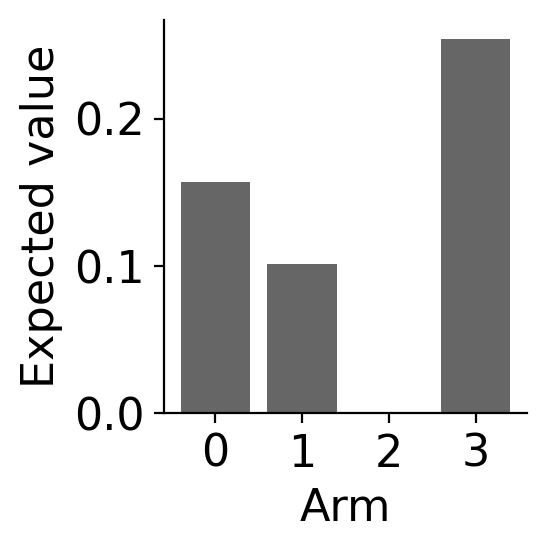

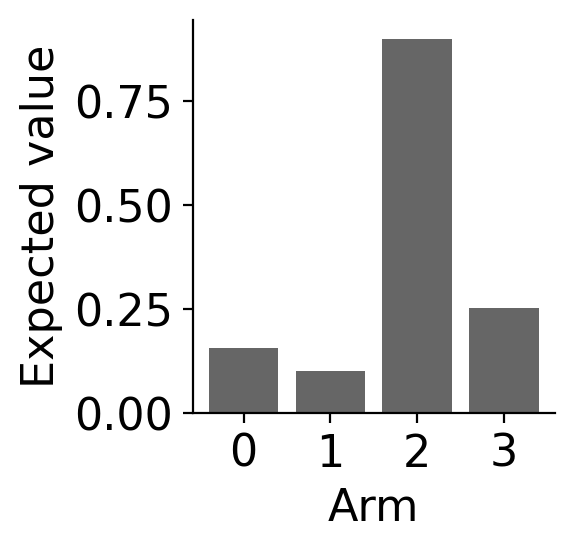

In [26]:
# Shared env params
seed = 5030

# plot env before
env1 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.0)
env1.seed(seed)
plot_bandit(env1, alpha=0.6)

# plot env after
env2 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.9)
env2.seed(seed)
plot_bandit(env2, alpha=0.6)

### Create this new changing bandit environment [3 pt]
To make the environment described above, set up a BanditChange4 environment with the following parameters:
- Have the number of trials before the change be 150.
- Have minimum and maximim probability of reward set to 0.1 and 0.3, respectively.
- Have the probability of reward for the "best" arm actually set to 0.0.
- Have the probability of reward for that arm after the change set to 0.9.
- Set the environment's seed to 5030.

In [27]:
seed = 5030
env = BanditChange4(num_change=150, p_min=0.1, p_max=0.3, p_best=0, p_change=0.9)
env.seed(seed)


[5030]

### Question 2.1 [4 pt]
When testing later on, we will have each experiment last for 175 steps. What makes this a tricky problem? What would an agent have to do to succeed in this task?

In [ ]:
# Since the method has to adapt to the change in probability at 150, the algortithm
# would need to adapt for the last 25 steps to still get greatest reward. Whether the
# agent is able to do this or not is what is difficult. Not only is it a short period
# of time to adapt, but it is also going to have likely originally found the arm
# with the greatest reward before the change.

### Creating the reinforcement learning agents [2 pt]

In the code cell below, fill in the code for creating each agent. Use the settings from the lab (repeated here for ease):
- Random agent: no settings needed
- Epsilon-greedy agent: use epsilon value of 0.1
- Upper confidence bound agent: use bonus weight of 0.5
- Softmax actor critic: use beta value of 7

In [28]:
ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms, tie_break='next', boredom=0.0),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0, bonus_weight=0.5)
)

sft = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, actions=None, beta=7),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)


agents = [ran, epy, ucb, sft]
names = ["random", "ep-greedy", "upper conf. bound", "softmax"]
colors = ["blue", "purple", "orange", "red"]

### Run the experiments [3 pt]

Fill in the code cell below to run 500 experiments for each agent, each with 175 steps. Set the seed to 5030 (have a code line for `seed=5030,` after the code line that sets the number of experiments).

In [35]:
num_experiments = 500

seed = 9030
env.seed(seed)

num_steps = 175
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
        seed=seed,
    )
    results.append(log)


random:   0%|          | 0/500 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/500 [00:00<?, ?it/s]

upper conf:   0%|          | 0/500 [00:00<?, ?it/s]

softmax:   0%|          | 0/500 [00:00<?, ?it/s]

### Visualize total rewards [3 pt]

In the code cell below, add code to plot the total reward for each agent type in the experiements.

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

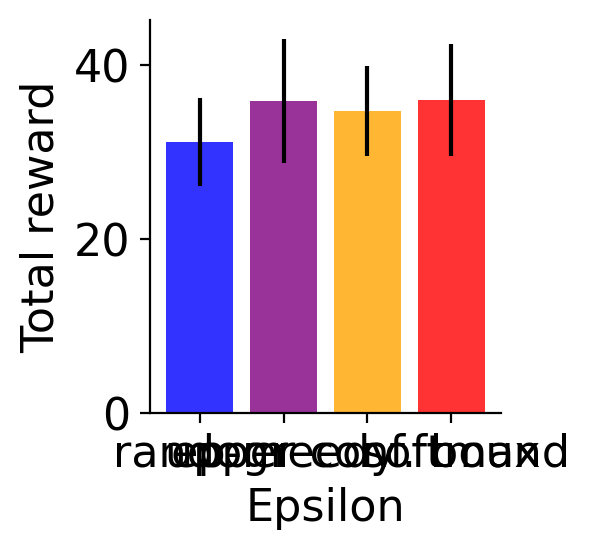

In [36]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

### Question 2.2 [4 pt]
How did each of the agents do, compared to one another? Why do you think this is the case?

In [ ]:
# Epsilon-greedy performed the best, followed by softmax, then ucb, and lastly
# random. This makes sense because the softmax and epsilon-greedy
# are in a loose sense greedy as they "exploit" an arm with higher reward. Since
# softmax does not necessarily exploit, we can clarify that the softmax agent
# will continue to estimate each arm based on reward and create a relative distribution
# so if one is 0.9 and 0.1 it will sample 0.9 more. This allows the agent to perform
# better than other agents after the change at 150 steps. In addition, the ucb agent
# will explore a lot at the beginning and then will shift to less likely to
# explore as time goes on. This makes it difficult to gain the most reward after
# the arm shifts. Lastly, it makes sense random performs the worst, as there is
# really no strategy for this agent.

### Question 2.3 [4 pt]

Re-run just the experiments and reward plotting with the following random seeds: 6030, 7030, 8030, and 9030. Make sure you are just changing the seed for the experiments, not for the bandit task itself.

How consistent are the results you see? What does this tell you about the stability of the patterns you described in Question 2.2? Why do you think this is the case?

In [ ]:
# At 6030, agents got closer in performance. However, random was still the worst-performing,
# followed by ucb. I cannot tell, but it appears epsilon-greedy and softmax agents
# performed the same as one another, with the same variation as well.

# At 7030, total reward decrease and agent performance changed completely. Ucb
# outperformed all other agents, followed by softmax, epsilon-greedy, and lastly
# random. Variability also increased noticeably for both softmax and epsilon-greedy.

# At 8030, the results changed again. Now, epsilon-greedy and softmax seem to
# perform evenly, but episolon-greedy had more variability. Ucb followed, and
# again random performed the worst.

# At 9030, epsilon-greedy and softmax perform the same, but with similar variability
# again. Ucb follows, but this time more closely. Lastly, random still performed
# the worst

# These results show an instability in all agents, except the random agent that
# consistently performs the worst, regardless of the seed. This instability across
# different seeds suggests that these agents' strategies are sensitive to variations.
# Despite their adaptive mechanisms, the varying patterns and shifts in performance
# indicate a lack of consistent superiority among the agents, except for the random
# agent.

---
## Part 3 - Exploration agents in information-distorted environments [26 pt]

In the last part of lab 8 we saw how the distortion in the channel driven by *missing information* influenced the efficiency of our Info agent. In this second part of the homework, you will investigate the effect of distortion driven by *sensor noise*.

Here we will test a range of *noise_sigma* (as opposed to *p_scent*) values. Essentially we will be turning *up* the distortion as *noise_sigma* increases. For these experiments we will hold the *p_scent* constant at 0.1 (a sparse information environment).

### Coding

In the code cells below, fill in (and run) code according to the text instructions before each one. Refer to lab 8 for help.

#### Install relevant code libraries.

In [ ]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-l66ccwkg
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-l66ccwkg
  Resolved https://github.com/coaxlab/explorationlib to commit 51e93ea9a3866d32202fb912bc46f7fcb18e8a17
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=41444 sha256=a7bbba75d8f94244a2b3920ab27445201b42175735e4937248983e87828b967a
  Stored in directory: /tmp/pip-ephem-wheel-cache-dqduydun/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-mh3li1r2
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-mh3li1r2
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

#### Import relevant modules.

In [ ]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

#### Add code for setting up pretty plots.

In [ ]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

### Code for running your experiments

We've provided some code below with *p_scent* set at the sparse-information value of 0.1. We also provide a range of *noise_sigma* that you will use. The range is on an exponential scale, just because it makes sense given that *noise_sigma* can only be 0 or greater.

In [ ]:
# Our parameters
p_scent = 0.1
noise_sigmas = [0.5625, 0.75, 1, 1.33, 1.77] # range of values on an exp. scale

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = noise_sigmas # list(range(5))

#### Complete the code below and run your experiments. We've specified the default parameters for the agent and environment below. Fill in the code for running experiments at each *noise_sigma* value within the loop below. (Add your code where it says `# ADD YOUR EXPERIMENT CODE HERE - BE SURE TO CHECK INDENTATION`.) [5 pt]

In [ ]:
# Define the accumulation parameters
drift_rate = 1
threshold = 1.5
accumulate_sigma = 1.0

# Shared
num_experiments = 100
num_steps = 400
seed_value = 5838

# Define non-scent probability values
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=drift_rate,
    threshold=threshold,
    accumulate_sigma=1
)
info.seed(seed_value)

# Run
results = []
Yeah
for i, noise_sigma in zip(names, noise_sigmas):
  # Targets
  prng = np.random.RandomState(seed_value)
  targets = uniform_targets(num_targets, target_boundary, prng=prng)
  values = constant_values(targets, 1)

  # Scents
  scents = []
  for _ in range(len(targets)):
      coord, scent = create_grid_scent_patches(
          target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
      scents.append(scent)

  # Env
  env = ScentGrid(mode=None)
  env.seed(seed_value)
  env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )

  results.append(exp)

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

#### Add in code below to plot the bumber of deaths for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [3 pt]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

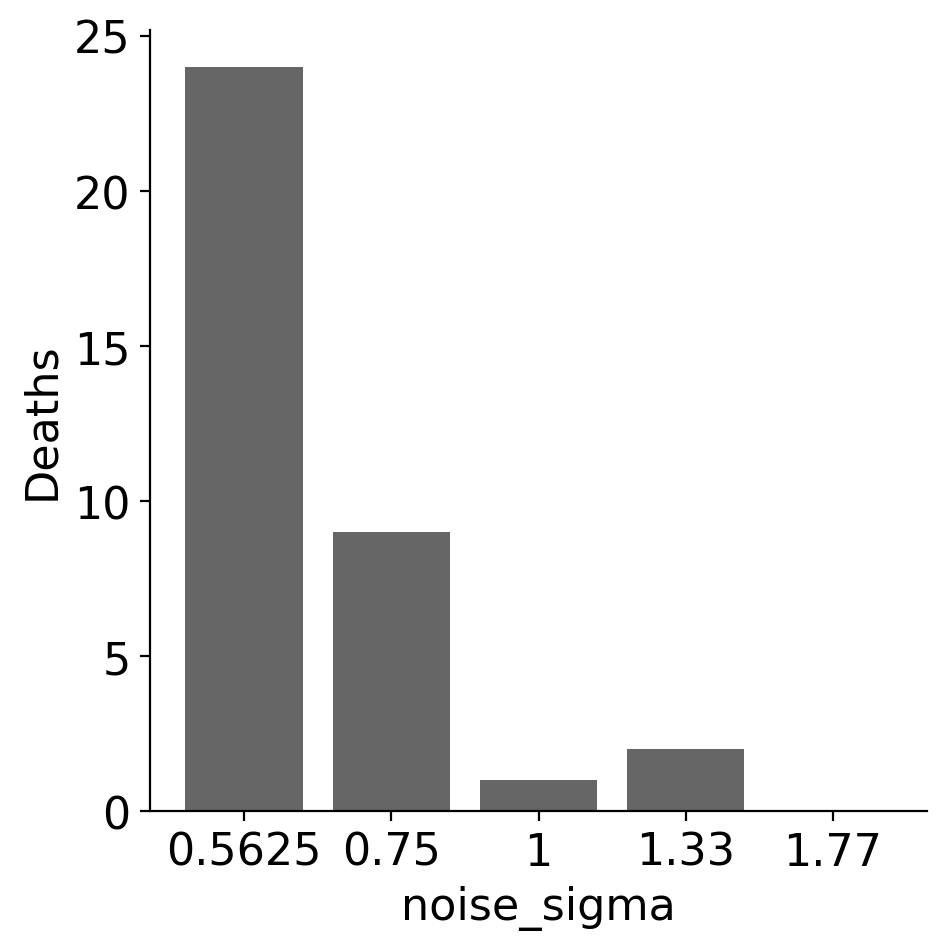

In [ ]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot max score for different values of *noise_sigma*. Make sure your x-axis is labeled with noise_sigma, not p_scent. [3 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

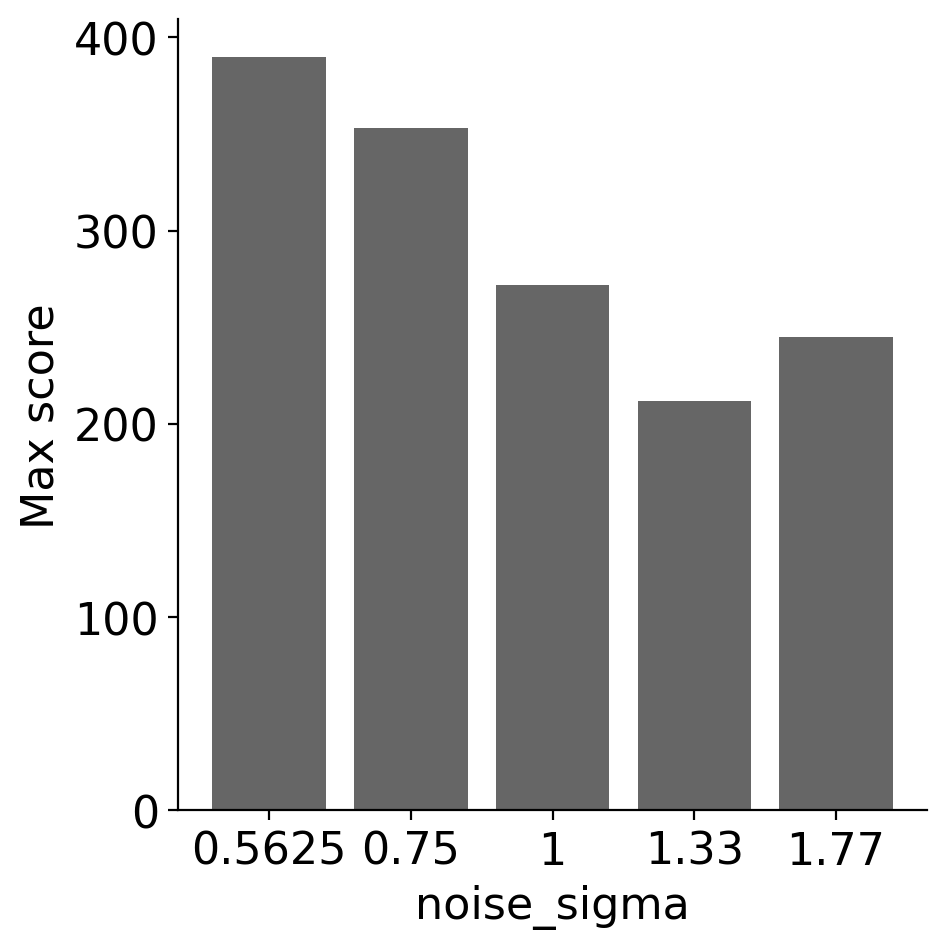

In [ ]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Max score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

#### Add in code below to plot average score and score frequency distributions for different values of *noise_sigma*. Make sure your x-axes are labeled with noise_sigma, not p_scent. [3 pt]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

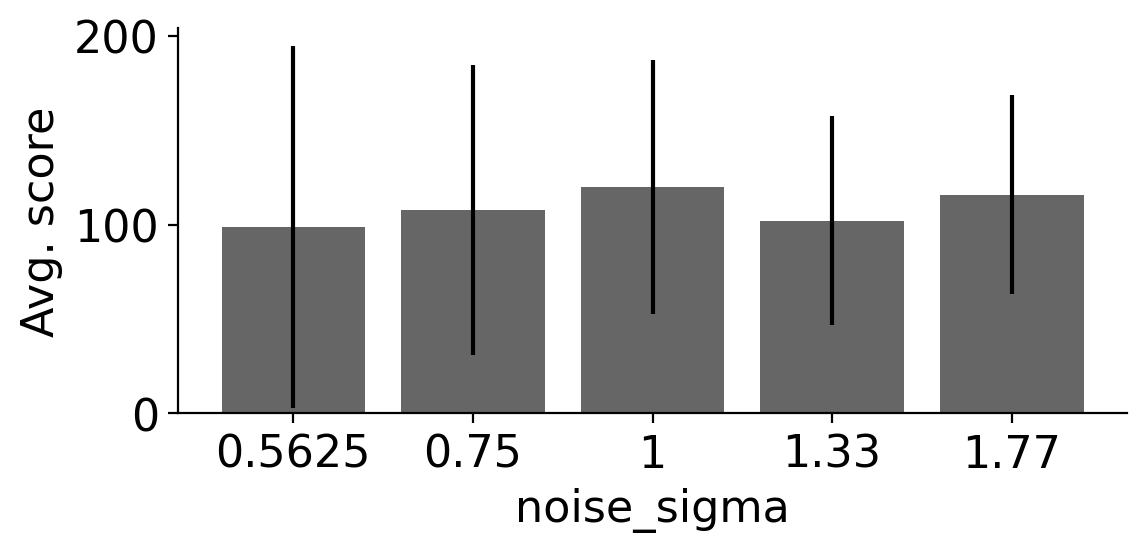

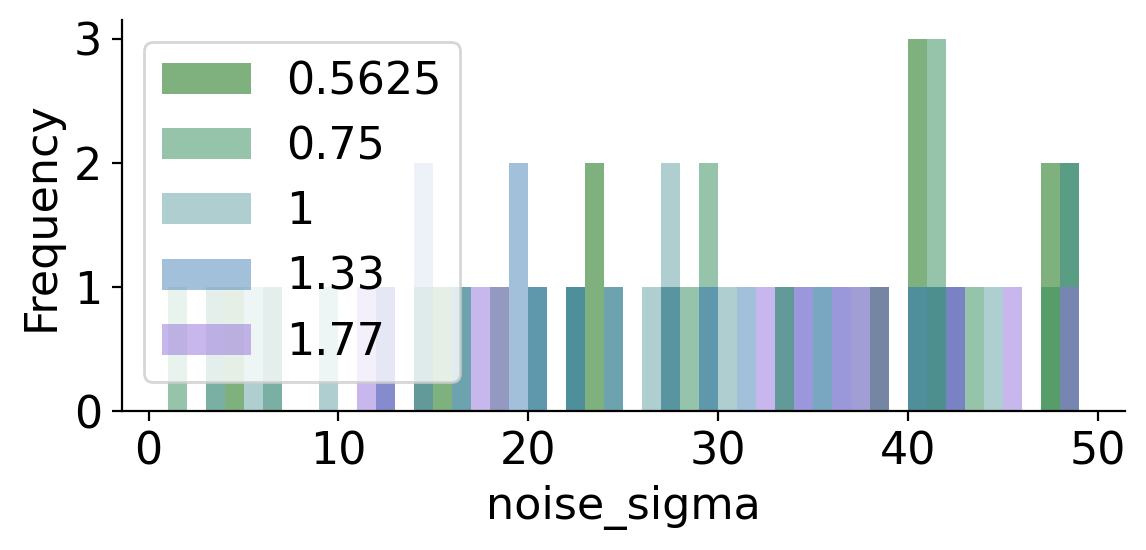

In [ ]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("noise_sigma")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("noise_sigma")
    plt.tight_layout()
    sns.despine()

### Question 3.1 [4 pt]

How does increasing *noise_sigma* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

In [ ]:
# Increasing noise_sigma seems to improve our info agent's performance. In particular,
# deaths trend downwards with an increase in noise while average scores trend upwards.
# However, max scores appear to peak at 0.75 and dip at 1.77 while remaining fairly
# level between the other three noise values.

# This particular pattern emerges since infotaxis can take advantage of missing
# scent information to drive their behavior. In this case, the environment has sparse
# information, so I assume an increase in noise almost encourages the agent to explore
# further, which leads the agent to a target more often.

### Question 3.2 [4 pt]

Re-run the simulations from this section, but now change the drift-rate from 1.0 to 0.75. How and why does this influence the agent's behavior (compared to the higher drift-rate)?

In [ ]:
# In terms of relation, the trends seem somewhat similar. However, there is an overall increase
# in deaths across scents. This is particularly important since all agents in the
# lowest two noise_sigmas die, which leaves them with no max or average score.

# This seems to show that there is slower accumulation of information or a need for
# more information to make a decision. In an environment with such sparse information
# and when noise is too low, it appears that agents cannot perform at all as they all die.

### Question 3.3 [4 pt]

Now set the drift-rate back to 1.0 and reduce the boundary height from 3.0 to 1.5. Re-run the simulations in again. How and why does this influence the agent's behavior (compared to the higher boundary height)?

In [ ]:
# Boundary height appears to have almost the opposite effect to drift-rate. Average scores
# seem to be pretty level across all noise_sigma values, max scores trend downwards
# as noise increases, and deaths substantially decrease across all values and trend
# downward as well (<20 at 0.5625 and 0 at 1.77).

# This influences the agent's behavior since it results in faster decision-making.
# Reducing the boundary height from 3.0 to 1.5 means the agent requires less evidence
# accumulation before reaching a decision, which is especially useful in this environment
# with sparse information.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> Will R, Alison S, Virginia Y, Olga M

**DUE:** 5pm ET, Nov. 27th, 2023. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.